##DATSCIW261 ASSIGNMENT #5

MIDS UC Berkeley, Machine Learning at Scale

DATSCIW261 ASSIGNMENT #4

Version 2016-02-18 (FINAL)

###HW 5.0

**What is a data warehouse?** 

A data warehouse is a central repository of integrated data used for reporting and analysis purposes. Typically the data is loaded into the warehouse from disparate sources, and the data undergoes preliminary processing to make it report-ready or analysis-ready. This process is referred to as "ETL" - Extract, Transform, and Load. 

An example of a data warehouse for a large company might be: data from sales, manufacturing, R&D, service, finance are all stored in the warehouse. The transform process might normalize data, one-hot encode data, and so on. 

**What is a Star schema? When is it used?**

A Star Schema is a star-shaped denormalized database schema that consists of two types of tables: Fact tables and Dimension tables. Fact tables contain measurable, quantitative data and Dimension tables contain descriptive data. For example, a fact table for a toy store would contain units made on particular dates, units sold on dates, where units are distributed. Corresponding dimension tables would contain toy models, colors, sizes, and other characteristics of the toys. 

Typically Dimension tables have fewer records but more attributes than Fact tables. Fact tables lie in the center of the Star Schema, with associated Dimension tables branching out from the central Fact tables. 

Star Schemas are useful in cases where certain queries about transactions are made frequently. For example, suppose a business sells Products in a collection of Stores. There would be many queries of a particular type such as how many products sold in certain periods; how many sold by location. It would make sense to build a Star Schema with transactions as the Fact table, and Dimension tables such as Date, Store, and Product. The Dimension tables would be small but hold all particulars about each dimension. 

In a MapReduce context, Dimension Tables could be held in memory or read into a hash table and the far larger Fact table used for streaming input. 

If relationships become too complex, a Star Schema might not be as useful. Star Schemas, since they are not normalized, have a risk of becoming inconsistent. 

###HW 5.1

**In the database world What is 3NF?** 
3NF stands for third normal form. A set of database tables is normalized if redundant information is removed. This aids in database consistency and accuracy; if values are repeated, they can get out of sync. There are several levels of normalization. 
First normal form: a table is in first normal form if and only if the domain of each attribute contains only atomic (indivisible) values, and the value of each attribute contains only a single value from that domain.

Second normal form: a table is in second normal form if it is in first normal form and no non-prime attribute is dependent on any proper subset of any candidate key of the table. A non-prime attribute of a table is an attribute that is not a part of any candidate key of the table. (A candidate key uniquely defines rows in the table). 

A table R is in 3NF if the following two conditions hold: 

- The relation R (table) is in second normal form (2NF)
- Every non-prime attribute of R is non-transitively dependent on every key of R.

3NF is a more rigorous normalization condition than first or second normal form. 

**Does machine learning use data in 3NF? If so why?**
Machine learning learns from samples. The samples have characteristics that a model can learn. For machine learning it is best to represent data with all of its characteristics present. In 3NF, information can be spread out in different tables. 

**In what form does ML consume data?**
ML consumes data as samples with collections of features. 

**Why would one use log files that are denormalized?**
To assemble all the features that could influence a model together. 

###HW 5.2

Using MRJob, implement a hashside join (memory-backed map-side) for left, 
right and inner joins. Run your code on the  data used in HW 4.4: (Recall HW 4.4: Find the most frequent visitor of each page using mrjob and the output of 4.2  (i.e., transfromed log file). In this output please include the webpage URL, webpageID and Visitor ID.)
:

Justify which table you chose as the Left table in this hashside join.

Please report the number of rows resulting from:

(1) Left joining Table Left with Table Right
(2) Right joining Table Left with Table Right
(3) Inner joining Table Left with Table Right

The two tables involved are: 

- a webpage URL table containing URLs and webpageID - composed of "A, " rows of the `anonymous-msweb.data` file. 

- a transaction table containing visited webpageID and visitorID for each visit. 

The first table is much smaller than the second and thus will be used as the Left table. 

In [1]:
%%writefile format_URL_data.py
#!/usr/bin/python
"""This program reformats the Microsoft anonymous visitor data.
In particular, customer IDs and corresponding visited site IDs
are placed on the same line. 
"""

import sys

checkV = False
prestring = ""

for line in sys.stdin:
    
    if line[:2] == "I,":
        line = line.strip()
        recI = line.split(",")
        prestring = recI[2].strip('"')
        
    elif line[:2] == "A,":
        line = line.strip()
        recA = line.split(",")
        #A,1288,1,"library","/library"
        print "%s,%s%s" % (recA[1],prestring,recA[4].strip('"'))


Overwriting format_URL_data.py


In [2]:
!chmod a+x format_URL_data.py

In [3]:
!cat ../HW4/anonymous-msweb.data | python format_URL_data.py > hw52input.txt

In [4]:
!head -n4 hw52input.txt

1287,www.microsoft.com/autoroute
1288,www.microsoft.com/library
1289,www.microsoft.com/masterchef
1297,www.microsoft.com/centroam


In [61]:
%%writefile hw52A.py

from mrjob.job import MRJob, MRStep
import mrjob
import csv
import sys

def csv_readline(line):
    """Hashed left join."""
    return csv.reader([line]).next()

class HashLeftJoin(MRJob):
    
    # Have to use Raw Protocol in order to get sorting (using 3rd key) to work.
    INTERNAL_PROTOCOL = mrjob.protocol.RawProtocol
    OUTPUT_PROTOCOL = mrjob.protocol.RawProtocol
    
    def mapper1(self, line_no, line):
        cell = csv_readline(line)
        # page,visitor \t count
        yield ",".join([cell[1], cell[4]]), "1"
        
    def reducer1(self, key, values):
        """Sum up the visit count per (page, visitor) pair."""
        total = sum([int(v) for v in values])
        fields = key.split(",")
        # page \t visitor \t total
        yield fields[0], "\t".join([fields[1], str(total)])

    def reducer2_init(self):
        # Build the dictionary of pageId:url
        self.urls = {}
        with open("hw42output.txt", "r") as f:
            for fields in csv.reader(f):
                self.urls[fields[0]] = fields[1]
                
    def reducer2(self, key, values):
        # url \t pageId \t visitor \t total
        yield self.BASE_URL + self.urls[key] + "\t" + key, values.next()
    
    def steps(self):
        return [
            MRStep(mapper=self.mapper1,
                   reducer=self.reducer1,
                  ),
            MRStep(reducer_init=self.reducer2_init,
                   reducer=self.reducer2,
                   jobconf={
                    "stream.num.map.output.key.fields":"3",
                    "mapreduce.job.output.key.comparator.class":
                        "org.apache.hadoop.mapred.lib.KeyFieldBasedComparator",
                    "mapreduce.partition.keycomparator.options":"-k3,3nr"
                          })]

    
if __name__ == '__main__':
    HashLeftJoin()

Writing hw52A.py


In [6]:
!chmod a+x hw52A.py

In [ ]:
from hw52A import HashLeftJoin
import csv

mr_job = HashLeftJoin(args=['./hw42output.txt'])
with mr_job.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        print mr_job.parse_output_line(line)

In [ ]:
%%writefile hw52B.py
#!/usr/bin/python
"""
Hashed table right join. 
"""
from mrjob.job import MRJob
from mrjob.step import MRStep
import csv

def csv_readline(line):
    """Given a sting CSV line, return a list of strings."""
    for row in csv.reader([line]):
        return row

class TopWords52B(MRJob):
    """
    This mrjob program performs in-memory hashed joins. 
    
    """
    
        
    def mapper_get_words(self, line_no, line):
        """This mapper connects read in lines with hashed URLs. """
        line = line.strip()
        
        rec = line.split("\t")
        words = rec[0].split(" ")
        for word in words:
            yield word,int(rec[1])
                  

    def reducer_count_words(self, word, counts):
        """xxx"""    
        #print "at first reducer"
        total = sum(i for i in counts)
        yield (total, word), total 
            
    def mapper_routekeys(self, word, total):
        """Sends key value pairs from Job 1 to hadoop shuffle for Job 2."""
        yield word, total
    
    def reducer_find10_init(self):
        self.count = 50
            
    def reducer_find_10_max(self,keyt,total):
        """Outputs the top ten counts and words."""    
        if self.count > 0: 
            
            yield keyt, total.next()
            self.count -= 1
            
                  
    def steps(self):
        return [
            MRStep(mapper=self.mapper_get_words,
                   reducer=self.reducer_count_words),
            MRStep(#mapper=self.mapper_routekeys,
                   reducer_init=self.reducer_find10_init,
                   reducer=self.reducer_find_10_max,
                   jobconf={
                    "stream.num.map.output.key.fields":"2",
                    "mapreduce.output.key.comparator.class":
                        "org.apache.hadoop.mapred.lib.KeyFieldBasedComparator",
                    "mapreduce.text.keycomparator.options":"-k1,1nr k2,2"
                          })
        ]

        
if __name__ == '__main__':
    TopWords52B.run()

###HW5.3.

EDA of googlebooks 5-grams using MrJob and EMR. 
Part 1: longest 5-gram and word count. 

In [38]:
%%writefile hw53A.py
#!/usr/bin/python
"""
Longest 5-gram.
"""
from mrjob.job import MRJob
from mrjob.step import MRStep

class TopWords53A(MRJob):

    def mapper_get_words(self, _, line):
        """
        Output line lengths and lines. 
        """
        line = line.strip()
        rec = line.split("\t")
        linelen = len(rec[0])
        yield "maxlen",(linelen, rec[0])  
        
    def combiner_maxlen(self, word, pairs):
        """
        Take the maximum line length. 
        """
        pl = list(pairs)
        lens = [e[0] for e in pl]
        maxidx = lens.index(max(lens))
        yield "maxlen", (pl[maxidx])

    def reducer_maxlen(self, word, pairs):
        """
        Take the maximum line length. 
        """ 
        pl = list(pairs)
        lens = [e[0] for e in pl]
        maxidx = lens.index(max(lens))
        yield pl[maxidx]

            
                  
    def steps(self):
        return [
            MRStep(mapper=self.mapper_get_words,
                   combiner=self.combiner_maxlen,
                   reducer=self.reducer_maxlen)
        ]
     
if __name__ == '__main__':
    TopWords53A.run()

Overwriting hw53A.py


In [39]:
!chmod a+x hw53A.py

In [40]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
from hw53A import TopWords53A
import csv

mr_job = TopWords53A(args=['./loc_test.txt'])
with mr_job.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        print mr_job.parse_output_line(line)

(33, 'A BILL FOR ESTABLISHING RELIGIOUS')


In [29]:
!cat loc_test.txt

A BILL FOR ESTABLISHING RELIGIOUS	59	59	54
A Biography of General George	92	90	74
A Case Study in Government	102	102	78
A Case Study of Female	447	447	327
A Case Study of Limited	55	55	43


In [75]:
%%writefile hw53B.py
#!/usr/bin/python
"""
Top ten most frequent words. 
"""
from mrjob.job import MRJob
from mrjob.step import MRStep

class TopWords53B(MRJob):
    """
    Finds the top ten most frequent words. 
    """

    def mapper_get_words(self, _, line):
        """Yield words and counts."""
        line = line.strip()
        line = line.lower()
        rec = line.split("\t")
        words = rec[0].split(" ")
        for word in words:
            yield word,int(rec[1])
                  

    def reducer_count_words(self, word, counts):
        """Add up the counts."""              
        total = sum(i for i in counts)
        yield word, total 
    
    def reducer_find10_init(self):
        self.count = 10000 #change back to 10
            
    def reducer_find_10_max(self,keyt,total):
        """Outputs the top ten counts and words."""              
        if self.count > 0:             
            yield keyt, total.next()
            self.count -= 1
            
                  
    def steps(self):
        return [
            MRStep(mapper=self.mapper_get_words,
                   reducer=self.reducer_count_words,
                   jobconf={
                            "mapred.map.tasks":28,
                            "mapred.reduce.tasks":28}),
            MRStep(#mapper=self.mapper_routekeys,
                   reducer_init=self.reducer_find10_init,
                   reducer=self.reducer_find_10_max,
                   jobconf={
                    "stream.num.map.output.key.fields":"2",
                    "mapreduce.job.output.key.comparator.class":
                        "org.apache.hadoop.mapred.lib.KeyFieldBasedComparator",
                    "mapreduce.partition.keycomparator.options":"-k2,2nr",
                    "mapred.reduce.tasks":1
                          })
        ]

        
if __name__ == '__main__':
    TopWords53B.run()

Overwriting hw53B.py


In [16]:
!chmod a+x hw53B.py

In [17]:
%load_ext autoreload
%autoreload 2

In [174]:
from hw53B import TopWords53B
import csv

mr_job = TopWords53B(args=['./loc_test.txt'])
with mr_job.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        print mr_job.parse_output_line(line)

The have been translated as follows
 mapreduce.job.output.key.comparator.class: mapred.output.key.comparator.class
mapreduce.partition.keycomparator.options: mapred.text.key.comparator.options
The have been translated as follows
 mapreduce.job.output.key.comparator.class: mapred.output.key.comparator.class
mapreduce.partition.keycomparator.options: mapred.text.key.comparator.options
The have been translated as follows
 mapreduce.job.output.key.comparator.class: mapred.output.key.comparator.class
mapreduce.partition.keycomparator.options: mapred.text.key.comparator.options
The have been translated as follows
 mapreduce.job.output.key.comparator.class: mapred.output.key.comparator.class
mapreduce.partition.keycomparator.options: mapred.text.key.comparator.options
The have been translated as follows
 mapreduce.job.output.key.comparator.class: mapred.output.key.comparator.class
mapreduce.partition.keycomparator.options: mapred.text.key.comparator.options
The have been translated as follows

('A', 755)
('BILL', 59)
('Biography', 92)
('Case', 604)
('ESTABLISHING', 59)
('FOR', 59)
('Female', 447)
('General', 92)
('George', 92)
('Government', 102)
('Limited', 55)
('RELIGIOUS', 59)
('Study', 604)
('in', 102)
('of', 594)


Command run: 

In [ ]:
!python hw53A.py -r emr --conf-path mrjob_261mas.conf s3://filtered-5grams/ \
    --output-dir=s3://peridot-261-marjorie/output53a01/

In [ ]:
%%writefile hw53C.py
#!/usr/bin/python
"""
Top 20 most/least densely appearing words. 
"""
from mrjob.job import MRJob
from mrjob.step import MRStep

class TopWords53C(MRJob):
    """
    TBD
    """

    def mapper_get_words(self, _, line):
        """xx"""
        line = line.strip()
        rec = line.split("\t")
        words = rec[0].split(" ")
        for word in words:
            yield word,int(rec[1])
                  

    def reducer_count_words(self, word, counts):
        """xxx"""              
        total = sum(i for i in counts)
        yield word, total 
    
    def reducer_find10_init(self):
        self.count = 10
            
    def reducer_find_10_max(self,keyt,total):
        """Outputs the top ten counts and words."""   
        if keyt == "*0_linelength":
            
        if self.count > 0: 
            
            yield keyt, total.next()
            self.count -= 1
            
                  
    def steps(self):
        return [
            MRStep(mapper=self.mapper_get_words,
                   reducer=self.reducer_count_words),
            MRStep(#mapper=self.mapper_routekeys,
                   reducer_init=self.reducer_find10_init,
                   reducer=self.reducer_find_10_max,
                   jobconf={
                    "stream.num.map.output.key.fields":"2",
                    "mapreduce.job.output.key.comparator.class":
                        "org.apache.hadoop.mapred.lib.KeyFieldBasedComparator",
                    "mapreduce.partition.keycomparator.options":"-k2,2nr"
                          })
        ]

        
if __name__ == '__main__':
    TopWords53C.run()

In [56]:
%%writefile hw53D.py
#!/usr/bin/python
"""
Frequency Distribution of 5-gram sizes.  
"""
from mrjob.job import MRJob
from mrjob.step import MRStep

class TopWords53D(MRJob):
    
    
    def mapper_get_words(self, _, line):
        """
        Output line lengths and lines. 
        """
        line = line.strip()
        rec = line.split("\t")
        linelen = len(rec[0])
        yield linelen, int(rec[1]) 
                  

    def reducer_count_lengths(self, linelen, count):
        """xxx"""              
        total = sum(i for i in count)
        yield linelen, total 
    

                  
    def steps(self):
        return [
            MRStep(mapper=self.mapper_get_words,
                   reducer=self.reducer_count_lengths,
                  jobconf={
                    "mapred.map.tasks":28,
                    "mapred.reduce.tasks":28})
            
        ]

        
if __name__ == '__main__':
    TopWords53D.run()

Overwriting hw53D.py


In [57]:
!chmod a+x hw53D.py

In [58]:
!python hw53D.py -r emr --conf-path mrjob_261mas.conf s3://filtered-5grams/ 
    --output-dir=s3://peridot-261-marjorie/output53d02


no configs found; falling back on auto-configuration
no configs found; falling back on auto-configuration
creating tmp directory /var/folders/5w/t79rkxsd09b8r67gk2nj_6640000gn/T/hw53D.marjoriesayer.20160215.234746.043411

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

writing to /var/folders/5w/t79rkxsd09b8r67gk2nj_6640000gn/T/hw53D.marjoriesayer.20160215.234746.043411/step-0-mapper_part-00000
writing to /var/folders/5w/t79rkxsd09b8r67gk2nj_6640000gn/T/hw53D.marjoriesayer.20160215.234746.043411/step-0-mapper_part-00001
writing to /var/folders/5w/t79rkxsd09b8r67gk2nj_6640000gn/T/hw53D.marjoriesayer.20160215.234746.043411/step-0-mapper_part-00002
writing to /var/folders/5w/t79rkxsd09b8r67gk2nj_6640000gn/T/hw53D.marjoriesayer.20160215.234746.043411/step-0-mapper_part-00003
writing to /var/folde

In [60]:
!cat sortedD53.txt 

9	14140
10	5740
11	31532
12	114018
13	888866
14	5950911
15	23247701
16	70338372
17	171644826
18	327102659
19	519029171
20	692585590
21	825593117
22	903382557
23	921800718
24	894422079
25	826976077
26	739311284
27	636987536
28	530179866
29	433764087
30	345711670
31	269584490
32	205588578
33	155555837
34	115556130
35	84419521
36	60137979
37	44027088
38	31113761
39	22259683
40	15560400
41	10971218
42	7704330
43	5169492
44	3568517
45	2600568
46	1603291
47	1175703
48	802590
49	551091
50	373875
51	230726
52	162867
53	94986
54	64675
55	58593
56	23339
57	22210
58	14919
59	8653
60	4388
61	4984
62	2544
63	2094
64	1449
65	1263
66	460
67	365
68	211
69	230
70	375
71	292
72	334
73	182
75	87
76	157
79	83
82	95
83	51
84	421
86	91
89	92
90	84
91	155
103	91
106	90
119	148
128	92
159	182


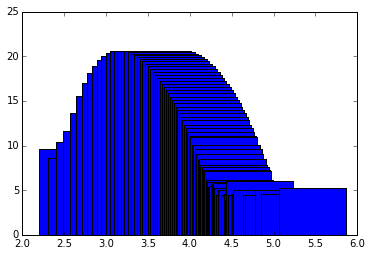

In [65]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

xvals = []
yvals = []
with open("sortedD53.txt", "rb") as f: 
    for line in f:
        line = line.strip()
        rec = line.split("\t")
        xvals.append(np.log(float(rec[0])))
        yvals.append(np.log(float(rec[1])))

plt.bar(xvals, yvals)
plt.show()
    

In [ ]:
from hw53D import TopWords53D
import csv

mr_job = TopWords53D(args=['./loc_test.txt'])
with mr_job.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        print mr_job.parse_output_line(line)

###HW5.4
HW 5.4  Synonym detection over 2Gig of Data

For the remainder of this assignment you will work with two datasets:

### 1: unit/systems test data set: SYSTEMS TEST DATASET
Three terms, A,B,C and their corresponding strip-docs of co-occurring terms

DocA {X:20, Y:30, Z:5}
DocB {X:100, Y:20}
DocC {M:5, N:20, Z:5}


### 2: A large subset of the Google n-grams dataset as was described above

For each HW 5.4 -5.5 Please unit test and system test your code with respect 
to SYSTEMS TEST DATASET and show the results. 
Please compute the expected answer by hand and show your hand calculations for the 
SYSTEMS TEST DATASET. Then show the results you get with you system.

In this part of the assignment we will focus on developing methods
for detecting synonyms, using the Google 5-grams dataset. To accomplish
this you must script two main tasks using MRJob:

(1) Build stripes for the most frequent 10,000 words using cooccurence informationa based on
the words ranked from 1001,-10,000 as a basis/vocabulary (drop stopword-like terms),
and output to a file in your bucket on s3 (bigram analysis, though the words are non-contiguous).


Hand calculation for comparison using test set:

`DocA {X:20, Y:30, Z:5}`

`DocB {X:100, Y:20}`

`DocC {M:5, N:20, Z:5}`

Using  the Jaccard similarity, we only take note of co-occurrence, not frequency. Hence the co-occurrence matrix is: 

`...M    N    X    Y    Z`

`A  0    0    1    1    1`

`B  0    0    1    1    0`

`C  1    1    0    0    1`

`J(A,B) = (1+1)/(1+1+1) = 2/3`

`J(A,C) = 1/5`

`J(B,C) = 0/5 = 0`

Using cosine similarity, the co-occurence matrix is: 

`...M    N    X    Y    Z`

`A  0    0    20   30   5` divide by sqrt(20<sup>2</sup> + 30<sup>2</sup> + 5<sup>2</sup>)

`B  0    0   100   20   0`

`C  5   20    0    0    5`





In [86]:
import numpy as np

def cosine_sim(a, b):
    numerator = 0.0
    for e in a: 
        if e in b:
            numerator += float(a[e]) * float(b[e])
    def denom(x):
        sq = [x[e]*x[e] for e in x]
        sumsq = float(sum(sq))
        denominator = np.sqrt(sumsq)
        return denominator
    denom_a = denom(a)
    denom_b = denom(b)
    if denom_a > 0 and denom_b > 0:
        return numerator/denom_a/denom_b
    
DocA = {'X':20, 'Y':30, 'Z':5}

DocB = {'X':100, 'Y':20}

DocC={'M':5, 'N':20, 'Z':5}

print "Cosine similarity DocA and DocB", cosine_sim(DocA, DocB)
print "Cosine similarity DocA and DocC", cosine_sim(DocA, DocC)
print "Cosine similarity DocB and DocC", cosine_sim(DocB, DocC)
            

Cosine similarity DocA and DocB 0.700404195972
Cosine similarity DocA and DocC 0.0323761954119
Cosine similarity DocB and DocC 0.0


First, we find the top 10,000 most frequent words and their counts using the code from HW5.3B. 

In [ ]:
!python hw53B.py -r emr --conf-path mrjob_261mas.conf s3://filtered-5grams/ 
    --output-dir=s3://peridot-261-marjorie/output54a01

In [ ]:
%%writefile hw54A.py
#!/usr/bin/python
"""
Build stripes for frequent words. 
"""
from mrjob.job import MRJob
from mrjob.step import MRStep

class BuildStripes54A(MRJob):
    """
    TBD
    """

    def mapper_init(self):
        """
        This makes the set of words to be used available
        to all mappers. 
        """
        self.freqw = set()
        with open("top_tenK.txt", "r") as f:
            for line in f:
                line = line.strip()
                rec = line.split("\t")
                word = rec[0].strip('"')
                self.freqw.update(word)
        
    
    def mapper_stripes(self, _, line):
        """start stripes"""
        line = line.strip()
        rec = line.split("\t")
        words = rec[0].split(" ")
        for term in words:
            if term not in self.freqw:
                continue
            for word in words:
                if word in self.freqw and word != term:
                    
                
            yield word,int(rec[1])
                  

    def reducer_count_words(self, word, counts):
        """xxx"""              
        total = sum(i for i in counts)
        yield word, total 
    
    def reducer_find10_init(self):
        self.count = 10
            
    def reducer_find_10_max(self,keyt,total):
        """Outputs the top ten counts and words."""   
        if keyt == "*0_linelength":
            
        if self.count > 0: 
            
            yield keyt, total.next()
            self.count -= 1
            
                  
    def steps(self):
        return [
            MRStep(mapper=self.mapper_get_words,
                   reducer=self.reducer_count_words),
            MRStep(#mapper=self.mapper_routekeys,
                   reducer_init=self.reducer_find10_init,
                   reducer=self.reducer_find_10_max,
                   jobconf={
                    "stream.num.map.output.key.fields":"2",
                    "mapreduce.job.output.key.comparator.class":
                        "org.apache.hadoop.mapred.lib.KeyFieldBasedComparator",
                    "mapreduce.partition.keycomparator.options":"-k2,2nr"
                          })
        ]

        
if __name__ == '__main__':
    BuildStripes54A.run()